# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    
    return (inputs, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha  = 0.2
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        return (tf.tanh(logits))
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
#     alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(data_shape[1],  data_shape[2],  data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples = []
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                print_every = 10
                show_every = 100
                show_img = 20
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % print_every == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))


                if steps % show_every == 0:
                    show_generator_output(sess, show_img, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 1.5334
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 1.1633
Epoch 1/2... Discriminator Loss: 0.7650... Generator Loss: 1.1142
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 3.5320
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 2.6436
Epoch 1/2... Discriminator Loss: 0.6255... Generator Loss: 1.3585
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.5195
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.5135
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 1.8515


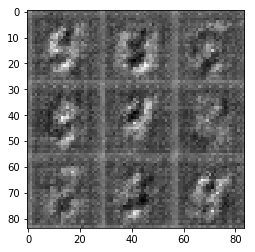

Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 1.4279
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.6620
Epoch 1/2... Discriminator Loss: 0.6204... Generator Loss: 1.0827
Epoch 1/2... Discriminator Loss: 0.4421... Generator Loss: 1.7536
Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 1.8151
Epoch 1/2... Discriminator Loss: 0.2901... Generator Loss: 2.4040
Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 0.9405
Epoch 1/2... Discriminator Loss: 0.2250... Generator Loss: 2.4553
Epoch 1/2... Discriminator Loss: 0.3120... Generator Loss: 3.7124
Epoch 1/2... Discriminator Loss: 0.1670... Generator Loss: 2.9205


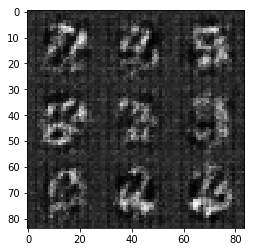

Epoch 1/2... Discriminator Loss: 0.1701... Generator Loss: 2.6941
Epoch 1/2... Discriminator Loss: 0.1469... Generator Loss: 2.7659
Epoch 1/2... Discriminator Loss: 0.1459... Generator Loss: 3.5727
Epoch 2/2... Discriminator Loss: 0.2141... Generator Loss: 2.0309
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 0.1844... Generator Loss: 2.3008
Epoch 2/2... Discriminator Loss: 0.2085... Generator Loss: 2.3239
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 4.9305
Epoch 2/2... Discriminator Loss: 0.1484... Generator Loss: 2.9527


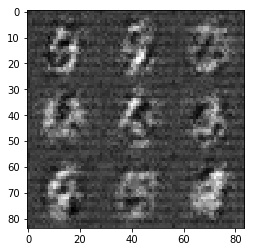

Epoch 2/2... Discriminator Loss: 0.2721... Generator Loss: 1.7667
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 0.2016... Generator Loss: 2.2828
Epoch 2/2... Discriminator Loss: 0.2576... Generator Loss: 1.9599
Epoch 2/2... Discriminator Loss: 0.3627... Generator Loss: 1.5020
Epoch 2/2... Discriminator Loss: 0.1366... Generator Loss: 3.5742
Epoch 2/2... Discriminator Loss: 0.1472... Generator Loss: 2.5828
Epoch 2/2... Discriminator Loss: 0.1173... Generator Loss: 3.2574
Epoch 2/2... Discriminator Loss: 0.1872... Generator Loss: 3.1700
Epoch 2/2... Discriminator Loss: 0.1508... Generator Loss: 3.6942


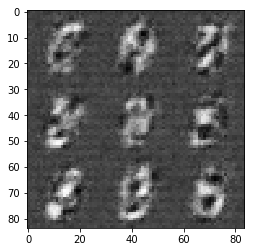

Epoch 2/2... Discriminator Loss: 0.1462... Generator Loss: 2.7991
Epoch 2/2... Discriminator Loss: 0.1168... Generator Loss: 2.8889
Epoch 2/2... Discriminator Loss: 0.1716... Generator Loss: 4.2125
Epoch 2/2... Discriminator Loss: 0.1261... Generator Loss: 3.4453
Epoch 2/2... Discriminator Loss: 0.2040... Generator Loss: 2.1489
Epoch 2/2... Discriminator Loss: 3.0542... Generator Loss: 10.8062


In [48]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 0.4482... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 1.8600
Epoch 1/1... Discriminator Loss: 0.2233... Generator Loss: 2.1583
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 2.7885
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.7133
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 2.0858


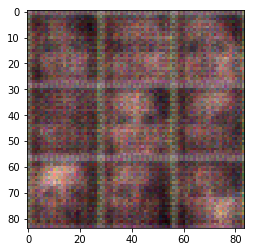

Epoch 1/1... Discriminator Loss: 0.3109... Generator Loss: 1.9241
Epoch 1/1... Discriminator Loss: 0.2602... Generator Loss: 2.1658
Epoch 1/1... Discriminator Loss: 0.2447... Generator Loss: 2.1927
Epoch 1/1... Discriminator Loss: 0.3072... Generator Loss: 1.7572
Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 3.0139
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 1.8112
Epoch 1/1... Discriminator Loss: 0.0921... Generator Loss: 3.3748
Epoch 1/1... Discriminator Loss: 0.1002... Generator Loss: 3.1678
Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 2.5994
Epoch 1/1... Discriminator Loss: 0.2190... Generator Loss: 2.2934


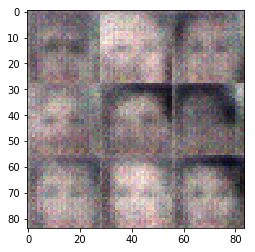

Epoch 1/1... Discriminator Loss: 0.3250... Generator Loss: 3.3447
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.0600... Generator Loss: 4.3041
Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 3.7315
Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 2.0603
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 4.5451
Epoch 1/1... Discriminator Loss: 0.2925... Generator Loss: 1.8328
Epoch 1/1... Discriminator Loss: 0.2605... Generator Loss: 2.2792
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 2.8635


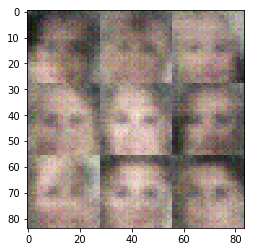

Epoch 1/1... Discriminator Loss: 0.1753... Generator Loss: 4.7480
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 5.6538
Epoch 1/1... Discriminator Loss: 0.0919... Generator Loss: 4.1223
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 1.5858
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 4.9914
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 5.2600
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 2.2554
Epoch 1/1... Discriminator Loss: 0.3186... Generator Loss: 1.7455
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 1.2611


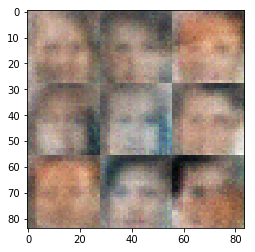

Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 2.7423
Epoch 1/1... Discriminator Loss: 0.1332... Generator Loss: 7.0498
Epoch 1/1... Discriminator Loss: 2.0811... Generator Loss: 0.1880
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.2651... Generator Loss: 4.7544
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 2.8989
Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 2.0996
Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 2.6865


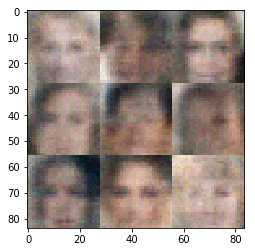

Epoch 1/1... Discriminator Loss: 0.2760... Generator Loss: 2.0202
Epoch 1/1... Discriminator Loss: 0.1199... Generator Loss: 4.3746
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 3.6091
Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 3.0000
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 2.5726
Epoch 1/1... Discriminator Loss: 0.3102... Generator Loss: 1.8255
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 3.4483
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 2.5835


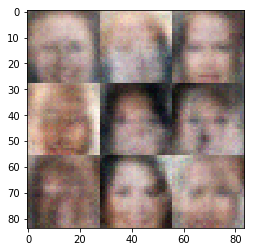

Epoch 1/1... Discriminator Loss: 0.1159... Generator Loss: 2.9227
Epoch 1/1... Discriminator Loss: 0.1572... Generator Loss: 2.5498
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 3.5434
Epoch 1/1... Discriminator Loss: 0.3121... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 3.7029
Epoch 1/1... Discriminator Loss: 0.2471... Generator Loss: 2.4811
Epoch 1/1... Discriminator Loss: 0.1155... Generator Loss: 3.5450
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 2.2653
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 0.1377... Generator Loss: 4.6351


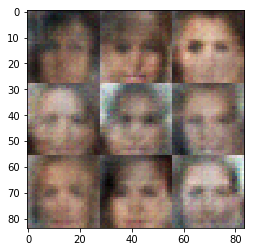

Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 3.5631
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 3.0432
Epoch 1/1... Discriminator Loss: 0.1494... Generator Loss: 2.4912
Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 3.4995
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 2.2798
Epoch 1/1... Discriminator Loss: 0.1753... Generator Loss: 5.1613
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 2.1554
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.1686... Generator Loss: 2.3039


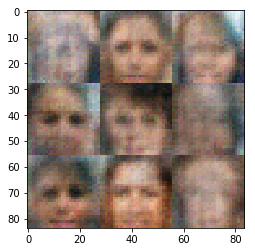

Epoch 1/1... Discriminator Loss: 0.2094... Generator Loss: 2.1416
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 0.0800... Generator Loss: 3.2257
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 2.2031
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 2.4256
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 3.3328
Epoch 1/1... Discriminator Loss: 0.0516... Generator Loss: 3.9549
Epoch 1/1... Discriminator Loss: 0.0684... Generator Loss: 3.2864
Epoch 1/1... Discriminator Loss: 0.1645... Generator Loss: 2.3065
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 1.5806


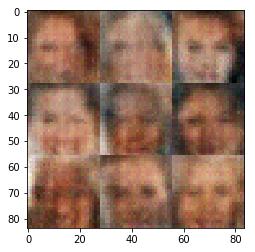

KeyboardInterrupt: 

In [49]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.